In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [2]:
from app_dataframe import df_hom

In [24]:
df = df_hom[['fecha','cantidad']]
df = df.set_index('fecha')
#probando mensualmente
df = df.resample('W').sum()
df.columns = ['#Passengers']
df.head()

,#Passengers
fecha,
2010-01-03,89
2010-01-10,139
2010-01-17,139
2010-01-24,140
2010-01-31,134


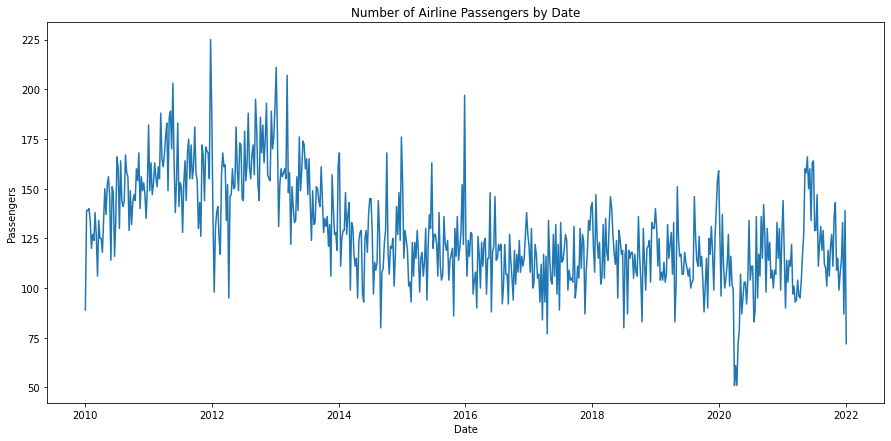

In [25]:
plt.figure(figsize=(15,7))
plt.title("Number of Airline Passengers by Date")
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.plot(df)
plt.show()

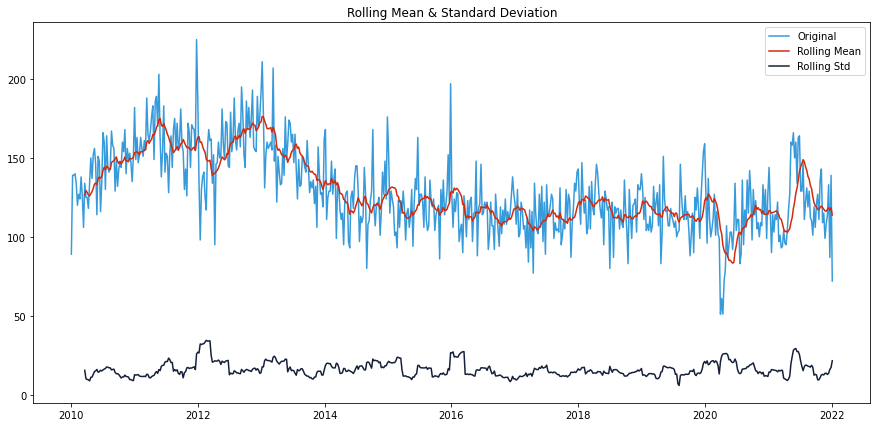

In [26]:
#Determine rolling statistics
df["rolling_avg"] = df["#Passengers"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df["#Passengers"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["#Passengers"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [27]:

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['#Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -2.254544
p-value                          0.187048
#Lags Used                      12.000000
Number of Observations Used    614.000000
Critical Value (1%)             -3.441045
Critical Value (5%)             -2.866259
Critical Value (10%)            -2.569283
dtype: float64


In [28]:

#Standard ARIMA Model
ARIMA_model = pm.auto_arima(df['#Passengers'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

c:\Users\mjsoto\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


c:\Users\mjsoto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


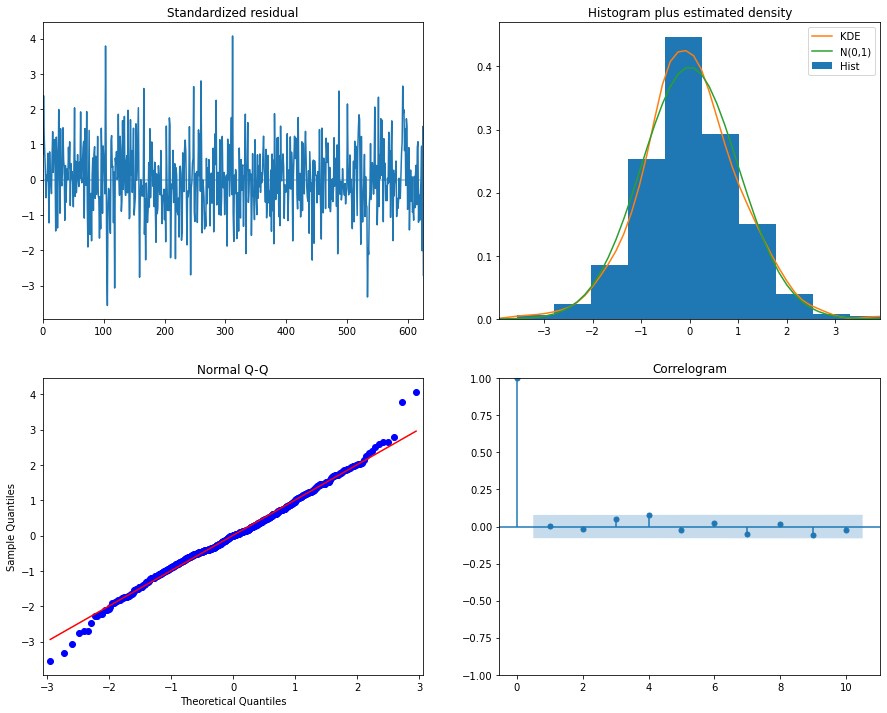

In [29]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

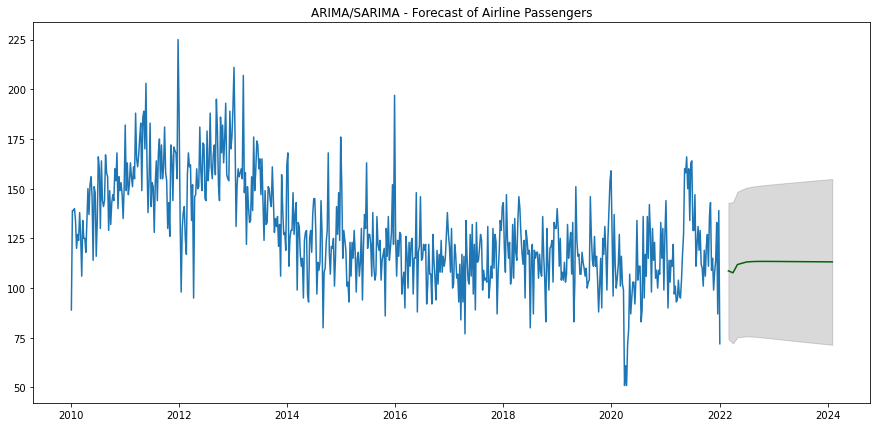

In [30]:
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

In [35]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["#Passengers"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=52, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

MemoryError: Unable to allocate 121. MiB for an array with shape (159, 159, 628) and data type float64

c:\Users\mjsoto\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


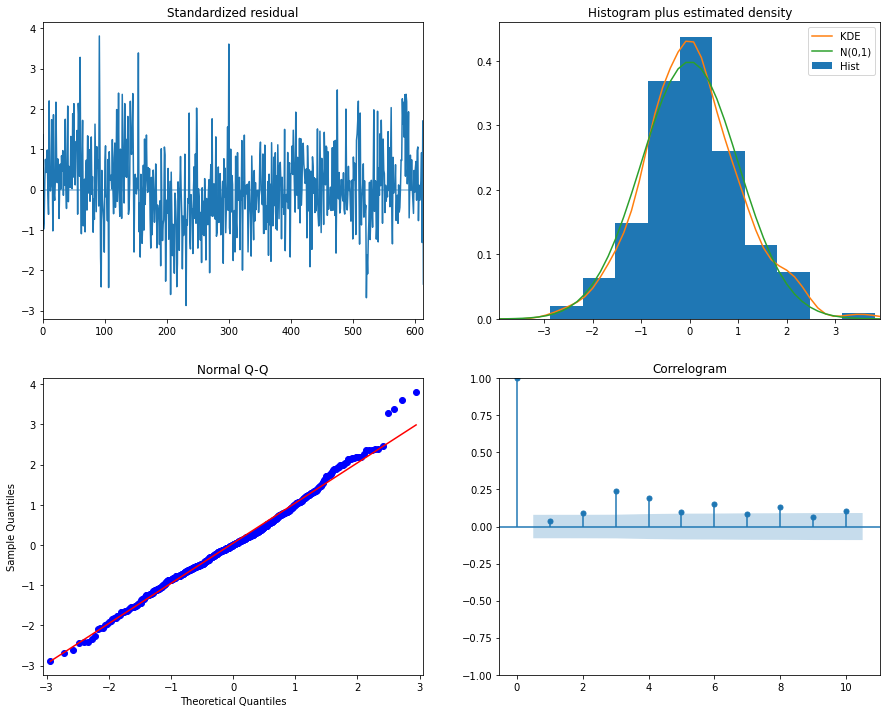

In [32]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

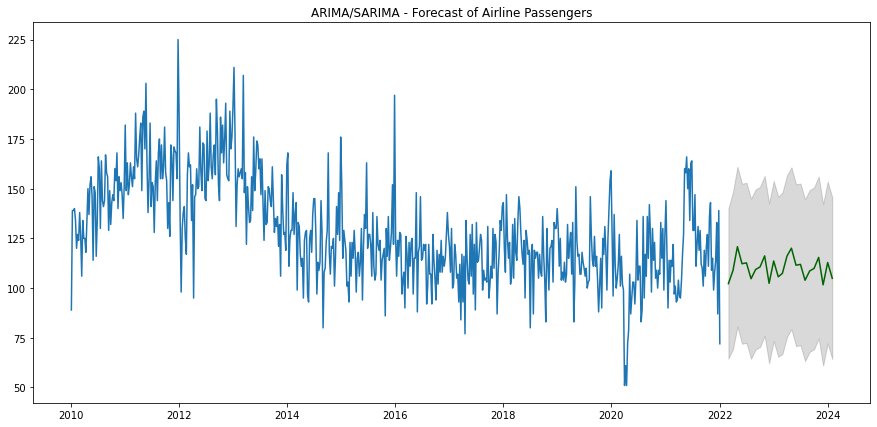

In [33]:
forecast(SARIMA_model)

In [34]:
#adding exogenous variable
df['month_index'] = df.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df[['#Passengers']], exogenous=df[['month_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

KeyboardInterrupt: 

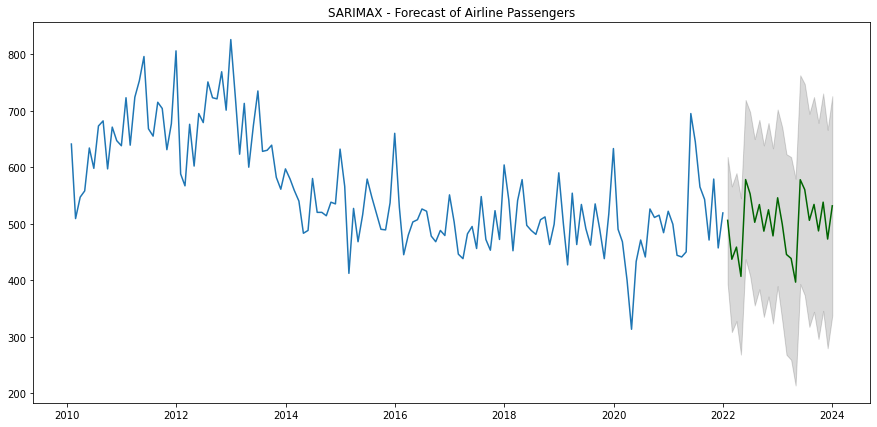

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['month_index']])
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["#Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)